In [1]:
import pandas as pd

splits = {'train': 'labeled_final/train-00000-of-00001.parquet', 'test': 'labeled_final/test-00000-of-00001.parquet', 'validation': 'labeled_final/validation-00000-of-00001.parquet'}


In [2]:
df = pd.read_parquet("hf://datasets/google-research-datasets/paws/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/paws/" + splits["test"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df_0 = df[df['label'] == 0].sample(n=1500, random_state=42)
df_1 = df[df['label'] == 1].sample(n=1500, random_state=42)

sentence_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print(sentence_df.head())
print(sentence_df['label'].value_counts())


      id                                          sentence1  \
0  42637  The Nelson River flows from Lake Winnipeg to P...   
1  10132  On 13 October 2010 , the Atlanta Braves announ...   
2  44443  The localized versions of subsequent games use...   
3  22636  Lord Stair married Emily Mary Julia Stonor , d...   
4  29404  Proteins that form stable complexes with bindi...   

                                           sentence2  label  
0  The Nelson River flows into Playgreen Lake fro...      1  
1  On October 13 , 2010 , the Atlanta Braves anno...      0  
2  The localized versions of subsequent games use...      1  
3  In 2006 , Lord Stair married Elizabeth Mary Hy...      0  
4  Proteins that form stable complexes with bindi...      1  
label
1    1500
0    1500
Name: count, dtype: int64


In [14]:
# Install necessary libraries
!pip install transformers torch torchvision

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SentenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        sentence1 = row['sentence1']
        sentence2 = row['sentence2']
        label = row['label']

        encoding1 = self.tokenizer(sentence1, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        encoding2 = self.tokenizer(sentence2, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids1': encoding1['input_ids'].squeeze(0),
            'attention_mask1': encoding1['attention_mask'].squeeze(0),
            'input_ids2': encoding2['input_ids'].squeeze(0),
            'attention_mask2': encoding2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }


class TwoBranchModel(nn.Module):
    def __init__(self):
        super(TwoBranchModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden_size = self.distilbert.config.hidden_size

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        h1 = self.distilbert(input_ids=input_ids1, attention_mask=attention_mask1).last_hidden_state[:, 0, :]
        h2 = self.distilbert(input_ids=input_ids2, attention_mask=attention_mask2).last_hidden_state[:, 0, :]

        combined = torch.cat([h1, h2, torch.abs(h1 - h2), h1 * h2], dim=1)
        output = self.fc(combined)
        return output


Using device: cuda


In [15]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
max_len = 128
batch_size = 16

dataset = SentenceDataset(sentence_df, tokenizer, max_len)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model, loss, and optimizer
model = TwoBranchModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}")

Epoch 1, Train Loss: 0.6947
Epoch 2, Train Loss: 0.6823
Epoch 3, Train Loss: 0.6384
Epoch 4, Train Loss: 0.4870
Epoch 5, Train Loss: 0.3268


In [17]:
import numpy as np
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = {}

    with torch.no_grad():
        for batch in val_loader:
            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze()
            all_labels.extend(labels.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.array(all_labels)

    for threshold in thresholds:
        binary_preds = (all_preds > threshold).astype(float)
        accuracy = accuracy_score(all_labels, binary_preds)
        conf_matrix = confusion_matrix(all_labels, binary_preds)
        results[threshold] = (accuracy, conf_matrix)

    return results

model.eval()



TwoBranchModel(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [18]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
result = evaluate_model(model, val_loader)

In [19]:
result

{0.1: (0.49833333333333335,
  array([[ 59, 229],
         [ 72, 240]])),
 0.2: (0.5016666666666667,
  array([[ 93, 195],
         [104, 208]])),
 0.30000000000000004: (0.515,
  array([[125, 163],
         [128, 184]])),
 0.4: (0.515,
  array([[147, 141],
         [150, 162]])),
 0.5: (0.5233333333333333,
  array([[172, 116],
         [170, 142]])),
 0.6: (0.5133333333333333,
  array([[187, 101],
         [191, 121]])),
 0.7000000000000001: (0.5066666666666667,
  array([[207,  81],
         [215,  97]])),
 0.8: (0.5083333333333333,
  array([[233,  55],
         [240,  72]])),
 0.9: (0.5083333333333333,
  array([[266,  22],
         [273,  39]]))}

Cross attention model

In [20]:
class CrossTwoBranchModel(nn.Module):
    def __init__(self, hidden_size=768, num_heads=8):
        super(CrossTwoBranchModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.hidden_size = hidden_size

        # Cross-Attention Mechanism
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads, batch_first=True)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Get embeddings from DistilBERT
        outputs1 = self.distilbert(input_ids=input_ids1, attention_mask=attention_mask1)
        outputs2 = self.distilbert(input_ids=input_ids2, attention_mask=attention_mask2)

        h1 = outputs1.last_hidden_state  # [batch_size, seq_len, hidden_size]
        h2 = outputs2.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Cross-Attention
        attended_h1, _ = self.cross_attention(h1, h2, h2)  # h1 attending to h2
        attended_h2, _ = self.cross_attention(h2, h1, h1)  # h2 attending to h1

        # Pooling (Take [CLS] token representation after attention)
        h1_cls = attended_h1[:, 0, :]  # First token from attended_h1
        h2_cls = attended_h2[:, 0, :]  # First token from attended_h2

        # Combine features
        combined = torch.cat([h1_cls, h2_cls, torch.abs(h1_cls - h2_cls), h1_cls * h2_cls], dim=1)

        # Classification
        output = self.fc(combined)
        return output


In [21]:

# Initialize tokenizer, dataset, and dataloaders
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
max_len = 128
batch_size = 16

dataset = SentenceDataset(sentence_df, tokenizer, max_len)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model, loss, and optimizer
model_2 = CrossTwoBranchModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids1, attention_mask1, input_ids2, attention_mask2).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}")

Epoch 1, Train Loss: 0.3939
Epoch 2, Train Loss: 0.2617
Epoch 3, Train Loss: 0.1978
Epoch 4, Train Loss: 0.1543
Epoch 5, Train Loss: 0.1233


In [22]:
result = evaluate_model(model_2, val_loader)
print(result)

{0.1: (0.5283333333333333, array([[  0, 283],
       [  0, 317]])), 0.2: (0.5283333333333333, array([[  0, 283],
       [  0, 317]])), 0.30000000000000004: (0.5283333333333333, array([[  0, 283],
       [  0, 317]])), 0.4: (0.5283333333333333, array([[  0, 283],
       [  0, 317]])), 0.5: (0.5283333333333333, array([[  0, 283],
       [  0, 317]])), 0.6: (0.4716666666666667, array([[283,   0],
       [317,   0]])), 0.7000000000000001: (0.4716666666666667, array([[283,   0],
       [317,   0]])), 0.8: (0.4716666666666667, array([[283,   0],
       [317,   0]])), 0.9: (0.4716666666666667, array([[283,   0],
       [317,   0]]))}


In [23]:
df_0 = df[df['label'] == 0].sample(n=1500, random_state=42)
df_1 = df[df['label'] == 1].sample(n=1500, random_state=42)

sentence_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

print(sentence_df.head())
print(sentence_df['label'].value_counts())


      id                                          sentence1  \
0  42637  The Nelson River flows from Lake Winnipeg to P...   
1  10132  On 13 October 2010 , the Atlanta Braves announ...   
2  44443  The localized versions of subsequent games use...   
3  22636  Lord Stair married Emily Mary Julia Stonor , d...   
4  29404  Proteins that form stable complexes with bindi...   

                                           sentence2  label  
0  The Nelson River flows into Playgreen Lake fro...      1  
1  On October 13 , 2010 , the Atlanta Braves anno...      0  
2  The localized versions of subsequent games use...      1  
3  In 2006 , Lord Stair married Elizabeth Mary Hy...      0  
4  Proteins that form stable complexes with bindi...      1  
label
1    1500
0    1500
Name: count, dtype: int64


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.eval()  # Set the model to evaluation mode

# Function to get sentence embeddings
def get_embeddings(sentences):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token representation
    return outputs.last_hidden_state[:, 0, :].numpy()

# Get embeddings for both sentences
sentence1_embeddings = get_embeddings(sentence_df["sentence1"].tolist())
sentence2_embeddings = get_embeddings(sentence_df["sentence2"].tolist())


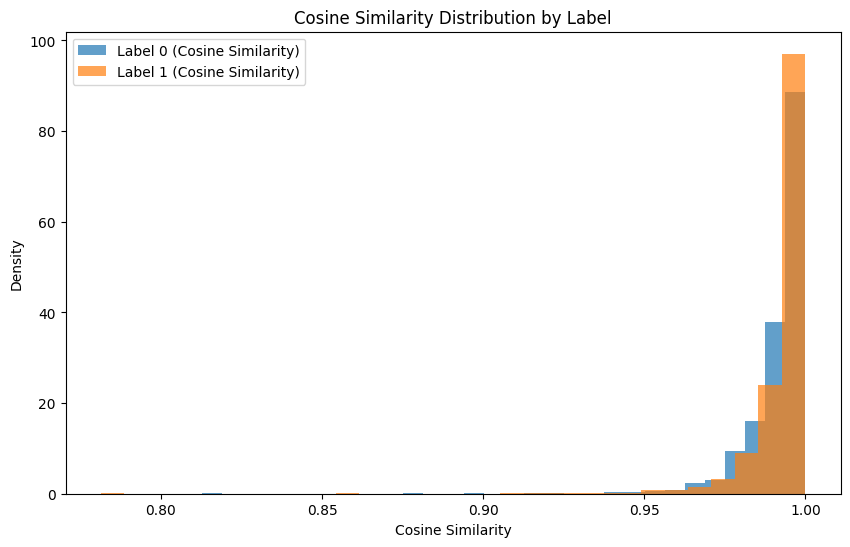

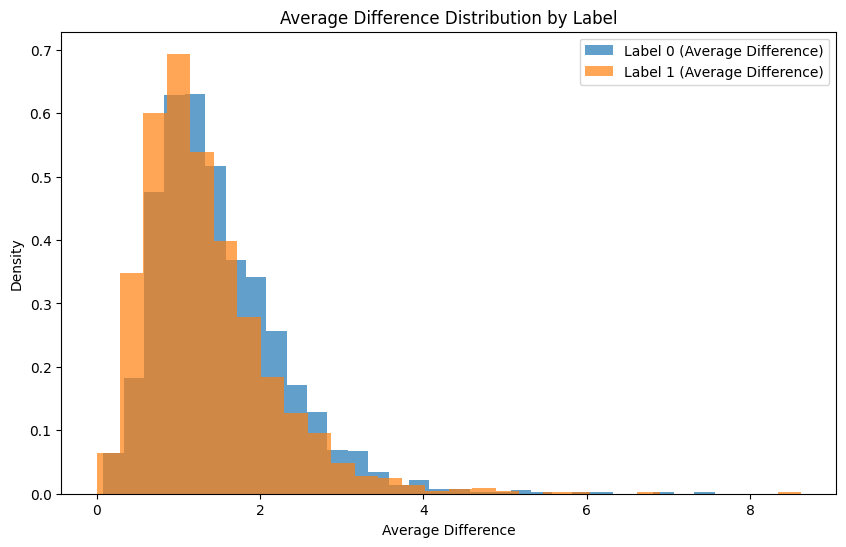

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

cos_sim = [cosine_similarity([s1], [s2])[0][0] for s1, s2 in zip(sentence1_embeddings, sentence2_embeddings)]
avg_diff = [
    torch.norm(torch.tensor(s1) - torch.tensor(s2)).item()
    for s1, s2 in zip(sentence1_embeddings, sentence2_embeddings)
]

# Add these metrics to the DataFrame
sentence_df["cosine_similarity"] = cos_sim
sentence_df["average_difference"] = avg_diff

# Separate by label for visualization
label_0 = sentence_df[sentence_df["label"] == 0]
label_1 = sentence_df[sentence_df["label"] == 1]

# Plotting Cosine Similarity Distributions
plt.figure(figsize=(10, 6))
plt.hist(label_0["cosine_similarity"], bins=30, alpha=0.7, label="Label 0 (Cosine Similarity)", density=True)
plt.hist(label_1["cosine_similarity"], bins=30, alpha=0.7, label="Label 1 (Cosine Similarity)", density=True)
plt.title("Cosine Similarity Distribution by Label")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.show()

# Plotting Average Difference Distributions
plt.figure(figsize=(10, 6))
plt.hist(label_0["average_difference"], bins=30, alpha=0.7, label="Label 0 (Average Difference)", density=True)
plt.hist(label_1["average_difference"], bins=30, alpha=0.7, label="Label 1 (Average Difference)", density=True)
plt.title("Average Difference Distribution by Label")
plt.xlabel("Average Difference")
plt.ylabel("Density")
plt.legend()
plt.show()

# Compute and return basic statistics for additional insights
stats = {
    "label_0": {
        "avg_cosine_similarity": label_0["cosine_similarity"].mean(),
        "avg_difference": label_0["average_difference"].mean(),
    },
    "label_1": {
        "avg_cosine_similarity": label_1["cosine_similarity"].mean(),
        "avg_difference": label_1["average_difference"].mean(),
    },
}